In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
# import Pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve

from sklearn.ensemble import RandomForestClassifier

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
emails = pd.read_csv('/content/train.csv')
# emails = emails[["text", "spam"]]
print(emails)

                                                   text  spam
0     information  shalesh ,  please , look into it ...     0
1     christmas baskets  kevin :  please add the cop...     0
2     re : credit rating contact ?  kim ,  i spoke w...     0
3     list of teams and projects  vince ,  here is t...     0
4     christmas baskets  the christmas baskets have ...     0
...                                                 ...   ...
3660  re : from vicky windsor  vicky ,  please , sen...     0
3661  fw : winston  debbie ,  this is an update on t...     0
3662  re : alp presentation  for your information , ...     0
3663  re : aiesec polska - eurolds 2000  drogi panie...     0
3664  phone numbers  computer support : 713 - 348 - ...     0

[3665 rows x 2 columns]


In [4]:
emails.groupby('spam').describe()

text                                                               
     count unique                                                top freq
spam                                                                     
0     2797   2781  re : contact info  glenn ,  please , contact r...    2
1      868    868  largest collection of porn mo \ / ies ever - x...    1

In [5]:
emails['length'] = emails['text'].map(lambda text: len(text))
print(emails.head())

                                                text  spam  length
0  information  shalesh ,  please , look into it ...     0    2404
1  christmas baskets  kevin :  please add the cop...     0    1198
2  re : credit rating contact ?  kim ,  i spoke w...     0     695
3  list of teams and projects  vince ,  here is t...     0     791
4  christmas baskets  the christmas baskets have ...     0     723


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

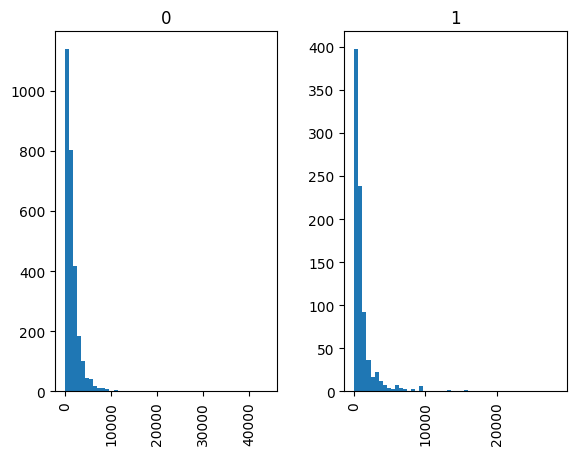

In [6]:
emails.hist(column='length', by='spam', bins=50)

In [7]:
def split_into_lemmas(email):
    email = email.lower()
    words = TextBlob(email).words
    # for each word, take its "base form" = lemma
    return [word.lemma for word in words]

emails.text.head().apply(split_into_lemmas)

0    [information, shalesh, please, look, into, it,...
1    [christmas, basket, kevin, please, add, the, c...
2    [re, credit, rating, contact, kim, i, spoke, w...
3    [list, of, team, and, project, vince, here, is...
4    [christmas, basket, the, christmas, basket, ha...
Name: text, dtype: object

In [8]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(emails['text'])
print(len(bow_transformer.vocabulary_))

28297


In [9]:
email_last = emails['text'].iloc[-1]
print (email_last)

phone numbers  computer support : 713 - 348 - 8319 ( help with computer connection )  suzanna vazquez : 713 - 348 - 3736 ( copies , etc . )  please let me know if you have any more questions or if i can help in any way .  pamela castro  mba program associate  rice university  713 - 348 - 6223


In [10]:
#checking last email
bow_l = bow_transformer.transform([email_last])
print (bow_l)
print (bow_l.shape)

  (0, 1316)	3
  (0, 1425)	1
  (0, 2111)	1
  (0, 2317)	3
  (0, 2601)	1
  (0, 4077)	2
  (0, 4421)	1
  (0, 6068)	1
  (0, 6231)	1
  (0, 7262)	2
  (0, 7434)	1
  (0, 7691)	1
  (0, 10521)	1
  (0, 12761)	1
  (0, 12889)	2
  (0, 13386)	1
  (0, 13475)	2
  (0, 13676)	1
  (0, 15116)	1
  (0, 15604)	1
  (0, 16632)	1
  (0, 16712)	1
  (0, 17364)	1
  (0, 18295)	1
  (0, 18720)	1
  (0, 19106)	1
  (0, 19648)	1
  (0, 19852)	1
  (0, 20565)	1
  (0, 20982)	1
  (0, 22111)	1
  (0, 24723)	1
  (0, 24820)	1
  (0, 26401)	1
  (0, 26801)	1
  (0, 27306)	1
  (0, 27680)	1
  (0, 28067)	1
(1, 28297)


In [11]:
print (bow_transformer.get_feature_names_out()[1316])
print (bow_transformer.get_feature_names_out()[2317])

348
713


In [12]:
emails_bow = bow_transformer.transform(emails['text'])
print ('sparse matrix shape:', emails_bow.shape)
print ('number of non-zeros:', emails_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * emails_bow.nnz / (emails_bow.shape[0] * emails_bow.shape[1])))

sparse matrix shape: (3665, 28297)
number of non-zeros: 462078
sparsity: 0.45%


In [13]:
tfidf_transformer = TfidfTransformer().fit(emails_bow)
tfidf_l = tfidf_transformer.transform(bow_l)
print(tfidf_l)

  (0, 28067)	0.037405688418395935
  (0, 27680)	0.04608802166163296
  (0, 27306)	0.0935723018739556
  (0, 26801)	0.24174726382471115
  (0, 26401)	0.09771170987453516
  (0, 24820)	0.25383620426265713
  (0, 24723)	0.10607824205565818
  (0, 22111)	0.13127051784940627
  (0, 20982)	0.08572868427500087
  (0, 20565)	0.09835291728983048
  (0, 19852)	0.05077540515638079
  (0, 19648)	0.09262140137143839
  (0, 19106)	0.19581890161660817
  (0, 18720)	0.05879391944992869
  (0, 18295)	0.08850676282950581
  (0, 17364)	0.0756891881648909
  (0, 16712)	0.05693964780276237
  (0, 16632)	0.14311606921608616
  (0, 15604)	0.07325321520335729
  (0, 15116)	0.06589635624742946
  (0, 13676)	0.04011651293546259
  (0, 13475)	0.10352140099622617
  (0, 13386)	0.04332813206294605
  (0, 12889)	0.17428190342322344
  (0, 12761)	0.04527112136516509
  (0, 10521)	0.1122367240304763
  (0, 7691)	0.1033704836840937
  (0, 7434)	0.1693639607098221
  (0, 7262)	0.2551926744203446
  (0, 6231)	0.19003014088896603
  (0, 6068)	0.05788

In [14]:
emails_tfidf = tfidf_transformer.transform(emails_bow)

## Trial

In [15]:
%time spam_detector = RandomForestClassifier(max_depth=5, n_estimators=10).fit(emails_tfidf, emails['spam'])

CPU times: user 88.2 ms, sys: 2.94 ms, total: 91.1 ms
Wall time: 98.8 ms


In [16]:
all_predictions = spam_detector.predict(emails_tfidf)
print (all_predictions)

[0 0 0 ... 0 0 0]


In [17]:
print ('accuracy', accuracy_score(emails['spam'], all_predictions))
print ('confusion matrix\n', confusion_matrix(emails['spam'], all_predictions))
print ('(row=expected, col=predicted)')

accuracy 0.8136425648021828
confusion matrix
 [[2797    0]
 [ 683  185]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

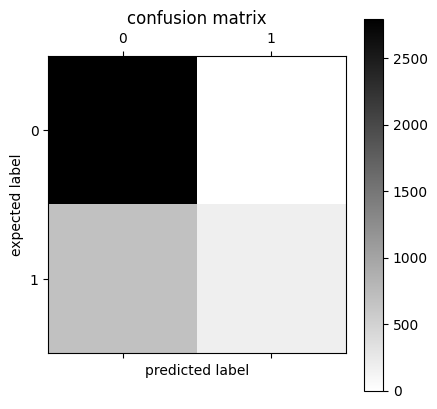

In [18]:
plt.matshow(confusion_matrix(emails['spam'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [19]:
print (classification_report(emails['spam'], all_predictions))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2797
           1       1.00      0.21      0.35       868

    accuracy                           0.81      3665
   macro avg       0.90      0.61      0.62      3665
weighted avg       0.85      0.81      0.76      3665



## All Data


In [20]:
train = pd.read_csv("train.csv")
val = pd.read_csv("validation.csv")
test = pd.read_csv("test.csv")

X_train, y_train = train["text"], train["spam"]
X_val, y_val = val["text"], val["spam"]
X_test, y_test = test["text"], test["spam"]

## Model 1 (Naïve Bayes)


In [21]:
pipeline_nb = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [22]:
%time model_nb = pipeline_nb.fit(X_train, y_train)

CPU times: user 20.8 s, sys: 100 ms, total: 20.9 s
Wall time: 21.1 s


In [23]:
print(model_nb.score(X_train, y_train))
print(model_nb.score(X_val, y_val))

0.8908594815825375
0.8625954198473282


In [24]:
predictions = model_nb.predict(X_test)
print (confusion_matrix(y_test, predictions))
print (classification_report(y_test, predictions))

[[856   0]
 [182 108]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       856
           1       1.00      0.37      0.54       290

    accuracy                           0.84      1146
   macro avg       0.91      0.69      0.72      1146
weighted avg       0.87      0.84      0.81      1146



## Model 2 (SVM Classifier)

In [25]:
pipeline_sv = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC()),  # train on TF-IDF vectors w/ SVM classifier
])

In [26]:
%time model_sv = pipeline_sv.fit(X_train, y_train)

CPU times: user 28.6 s, sys: 140 ms, total: 28.8 s
Wall time: 29.3 s


In [27]:
print(model_sv.score(X_train, y_train))
print(model_sv.score(X_val, y_val))

1.0
0.9880043620501636


In [28]:
predictions = model_sv.predict(X_test)
print (confusion_matrix(y_test, predictions))
print (classification_report(y_test, predictions))

[[854   2]
 [ 11 279]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       856
           1       0.99      0.96      0.98       290

    accuracy                           0.99      1146
   macro avg       0.99      0.98      0.98      1146
weighted avg       0.99      0.99      0.99      1146



## Model 3 (Decision Tree)

In [29]:
pipeline_dt = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier',  DecisionTreeClassifier()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [30]:
%time model_dt = pipeline_dt.fit(X_train, y_train)

CPU times: user 22.2 s, sys: 78.9 ms, total: 22.2 s
Wall time: 22.5 s


In [31]:
print(model_dt.score(X_train, y_train))
print(model_dt.score(X_val, y_val))

1.0
0.945474372955289


In [32]:
predictions = model_dt.predict(X_test)
print (confusion_matrix(y_test, predictions))
print (classification_report(y_test, predictions))

[[827  29]
 [ 33 257]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       856
           1       0.90      0.89      0.89       290

    accuracy                           0.95      1146
   macro avg       0.93      0.93      0.93      1146
weighted avg       0.95      0.95      0.95      1146



We see that the SVM Classifier `model_sv` performs best on the test data, followed by decision trees, then naïve bayes.